In [5]:
import pickle 
import glob
import os

In [4]:
# --- 4) Load gene_dict pickles
PICKLE_DIR = "/Users/harsh/Documents/gene_dicts_out_complete_and_filtered/with_PFP_predictions_complete"
gene_dicts = {}
for pkl in glob.glob(f"{PICKLE_DIR}/*_gene_dict_with_PFP.pkl"):
    key = os.path.basename(pkl).split("_gene_dict")[0]
    with open(pkl, "rb") as f:
        gene_dicts[key] = pickle.load(f)

In [6]:
len(gene_dicts['PlasmoDB-68_PinuiSanAntonio1'])

5832

In [19]:
import pandas as pd 

curated_keys = [
    ('GO Function', 'GO IEA Function'),
    ('GO Process', 'GO IEA Process'),
    ('GO Component', 'GO IEA Component'),
]

# Define PFP keys and thresholds
pfp_keys = {
    'MF': 'PFP MF',
    'BP': 'PFP BP',
    'CC': 'PFP CC'
}
thresholds = [0.01, 0.05, 0.1, 0.2, 0.3]

# Prepare a list to collect stats
records = []

for species, genes in gene_dicts.items():
    # Curated-only stats
    curated_counts = {'species': species}
    curated_stats = {'unannotated': 0, 'partially_annotated': 0, 'fully_annotated': 0}
    
    # Initialize threshold stats
    threshold_stats = {
        t: {'unannotated': 0, 'partially_annotated': 0, 'fully_annotated': 0}
        for t in thresholds
    }
    
    for gene_id, annot in genes.items():
        # Check curated annotation presence by ontology
        curated_presence = []
        for non_iea_key, iea_key in curated_keys:
            non_iea = annot.get(non_iea_key, [])
            iea = annot.get(iea_key, [])
            curated_presence.append(bool(non_iea or iea))
        
        # Determine curated-only category
        if not any(curated_presence):
            curated_stats['unannotated'] += 1
        elif all(curated_presence):
            curated_stats['fully_annotated'] += 1
        else:
            curated_stats['partially_annotated'] += 1
        
        # Now include PFP predictions at each threshold
        for t in thresholds:
            pfp_presence = []
            for ont, pfp_key in pfp_keys.items():
                # curated + PFP
                curated_any = curated_presence[['MF','BP','CC'].index(ont)]
                pfp_dict = annot.get(pfp_key, {})
                preds = pfp_dict.get(t, set())
                pfp_presence.append(bool(curated_any or preds))
            
            if not any(pfp_presence):
                threshold_stats[t]['unannotated'] += 1
            elif all(pfp_presence):
                threshold_stats[t]['fully_annotated'] += 1
            else:
                threshold_stats[t]['partially_annotated'] += 1
    
    # Record into list
    # Curated-only row
    row = {
        'species': species,
        'threshold': 'curated_only',
        **curated_stats
    }
    records.append(row)
    # Per-threshold rows
    for t, stats in threshold_stats.items():
        row = {
            'species': species,
            'threshold': t,
            **stats
        }
        records.append(row)

# Create DataFrame and display
df = pd.DataFrame(records)
df = df.set_index(['species', 'threshold'])


In [8]:
df.to_csv("gene_annotation_stats_with_PFP_new_threshold.csv")

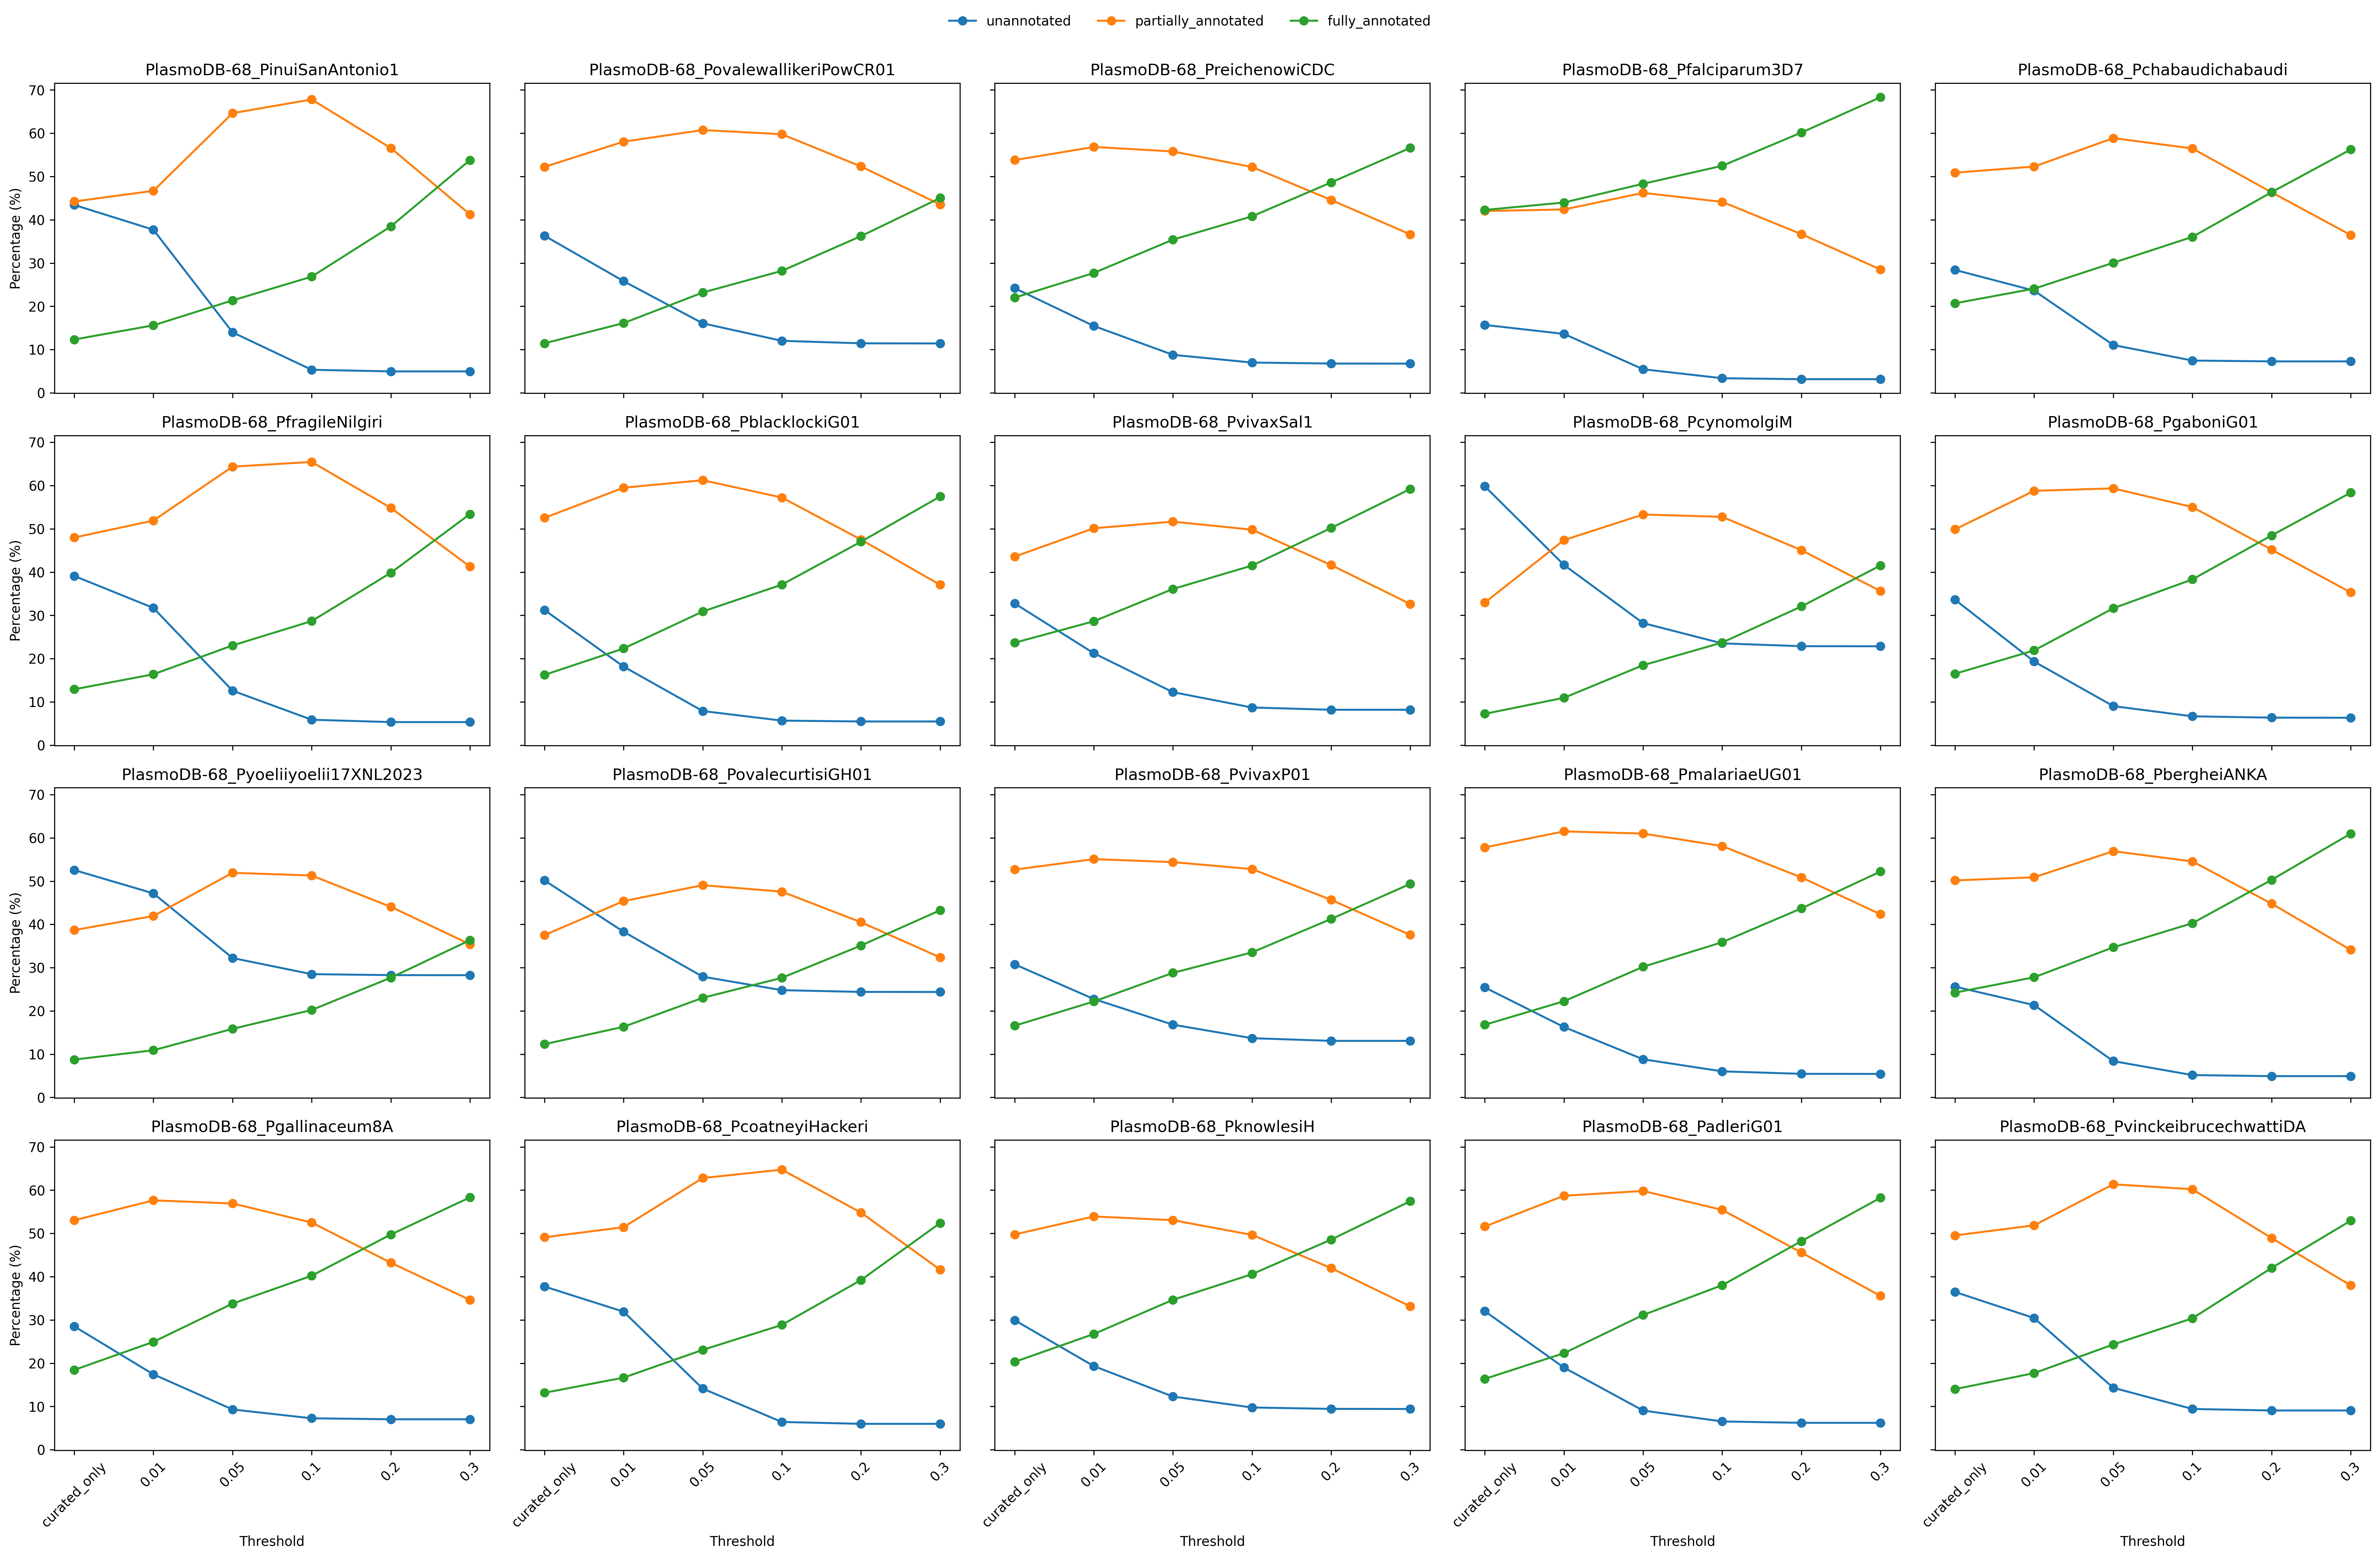

In [20]:
import matplotlib.pyplot as plt
import numpy as np

species_list = df.index.get_level_values('species').unique()
n = len(species_list)
cols = 5
rows = int(np.ceil(n/cols))

# sharex=True, sharey=True makes every subplot use the same x‐ and y‐limits
fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4),
                         sharex=True, sharey=True, squeeze=False)
#set dpi to 300
fig.dpi = 300
def sort_key(t):
    return -1 if t=='curated_only' else float(t)

for ax, sp in zip(axes.flatten(), species_list):
    sub = df.xs(sp).reset_index()
    sub['order'] = sub['threshold'].apply(sort_key)
    sub = sub.sort_values('order')
    
    counts = sub[['unannotated','partially_annotated','fully_annotated']]
    pct = counts.div(counts.sum(axis=1), axis=0) * 100
    
    x = np.arange(len(sub))
    labels = sub['threshold'].astype(str)
    for col in pct.columns:
        ax.plot(x, pct[col], marker='o', label=col)
    
    ax.set_title(sp)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45)

# Because they’re shared, you only need to label the outer axes:
for ax in axes[-1]:  # bottom row
    ax.set_xlabel('Threshold')
for ax in axes[:,0]:  # left column
    ax.set_ylabel('Percentage (%)')

# Hide any unused subplots
for ax in axes.flatten()[n:]:
    ax.set_visible(False)
handles, labels = axes.flatten()[0].get_legend_handles_labels()

# Add a single legend above all subplots
fig.legend(
    handles,
    labels,
    loc='upper center',        # place at top center
    ncol=len(labels),          # one column per category
    frameon=False,             # no box around it
    bbox_to_anchor=(0.5, 1.02) # slightly above the figure
)

fig.tight_layout(rect=[0, 0, 1, 0.99])  # leave space at top for legend
plt.show()
fig.tight_layout()
plt.show()


In [21]:
#rename species 
species_to_name = {'PlasmoDB-68_PadleriG01': 'P. adleri',
             'PlasmoDB-68_PbergheiANKA': 'P. berghei',
             'PlasmoDB-68_PblacklockiG01': 'P. blacklocki',
             'PlasmoDB-68_Pchabaudichabaudi': 'P. chabaudi',
             'PlasmoDB-68_PcoatneyiHackeri': 'P. coatneyi',
             'PlasmoDB-68_PcynomolgiM': 'P. cynomolgi',
             'PlasmoDB-68_Pfalciparum3D7': 'P. falciparum',
             'PlasmoDB-68_PfragileNilgiri': 'P. fragile',
             'PlasmoDB-68_PgaboniG01': 'P. gaboni',
             'PlasmoDB-68_Pgallinaceum8A': 'P. gallinaceum',
             'PlasmoDB-68_PinuiSanAntonio1': 'P. inui',
             'PlasmoDB-68_PknowlesiH': 'P. knowlesi',
             'PlasmoDB-68_PmalariaeUG01': 'P. malariae',
             'PlasmoDB-68_PovalecurtisiGH01': 'P. ovale curtisi',
             'PlasmoDB-68_PovalewallikeriPowCR01': 'P. ovale wallikeri',
             'PlasmoDB-68_PreichenowiCDC': 'P. reichenowi',
             'PlasmoDB-68_PvinckeibrucechwattiDA': 'P. vinckei',
             'PlasmoDB-68_PvivaxP01': 'P. vivax P01',
             'PlasmoDB-68_PvivaxSal1': 'P. vivax',
             'PlasmoDB-68_Pyoeliiyoelii17XNL2023': 'P. yoelii'}

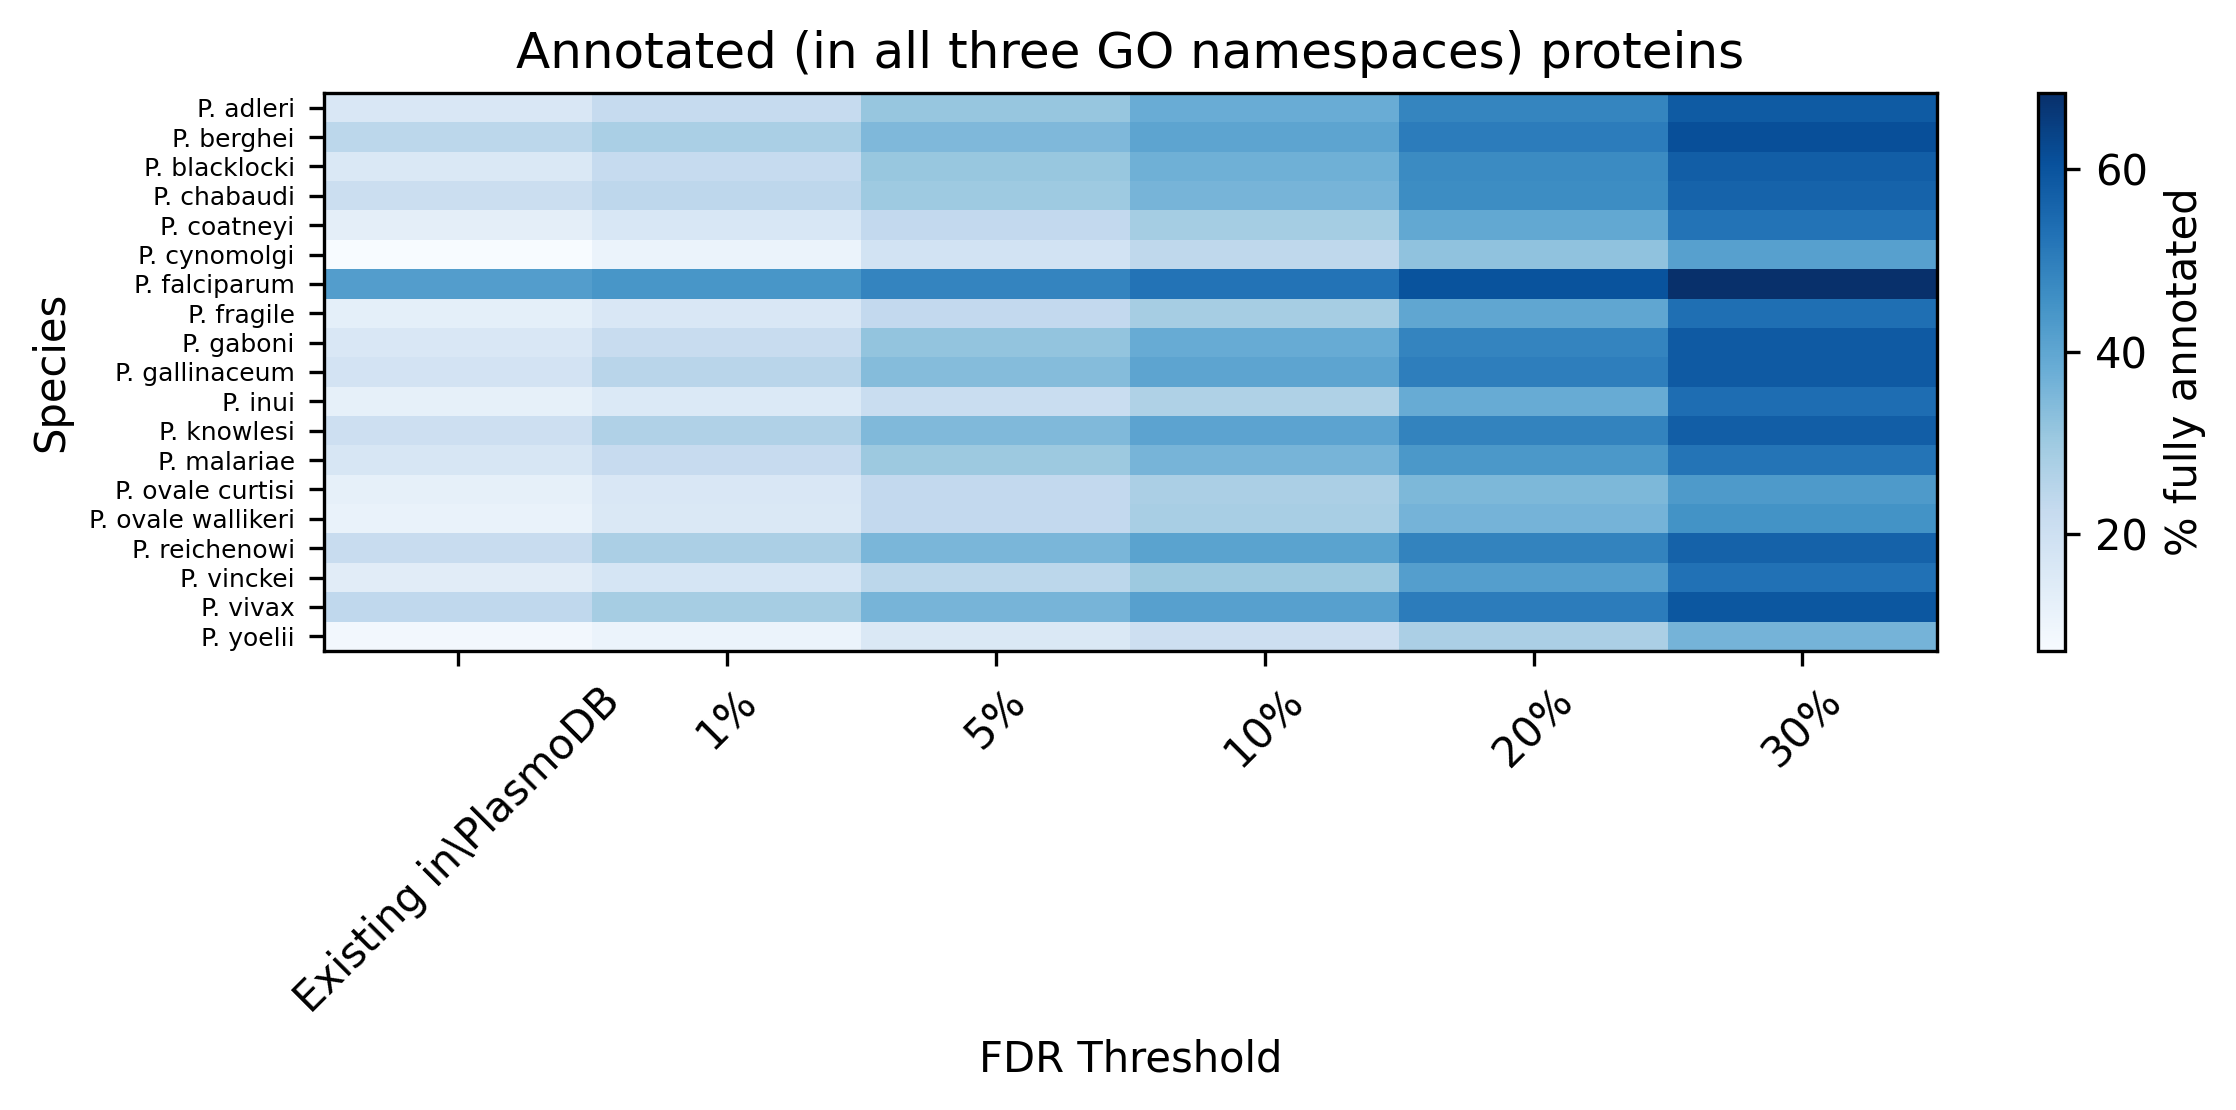

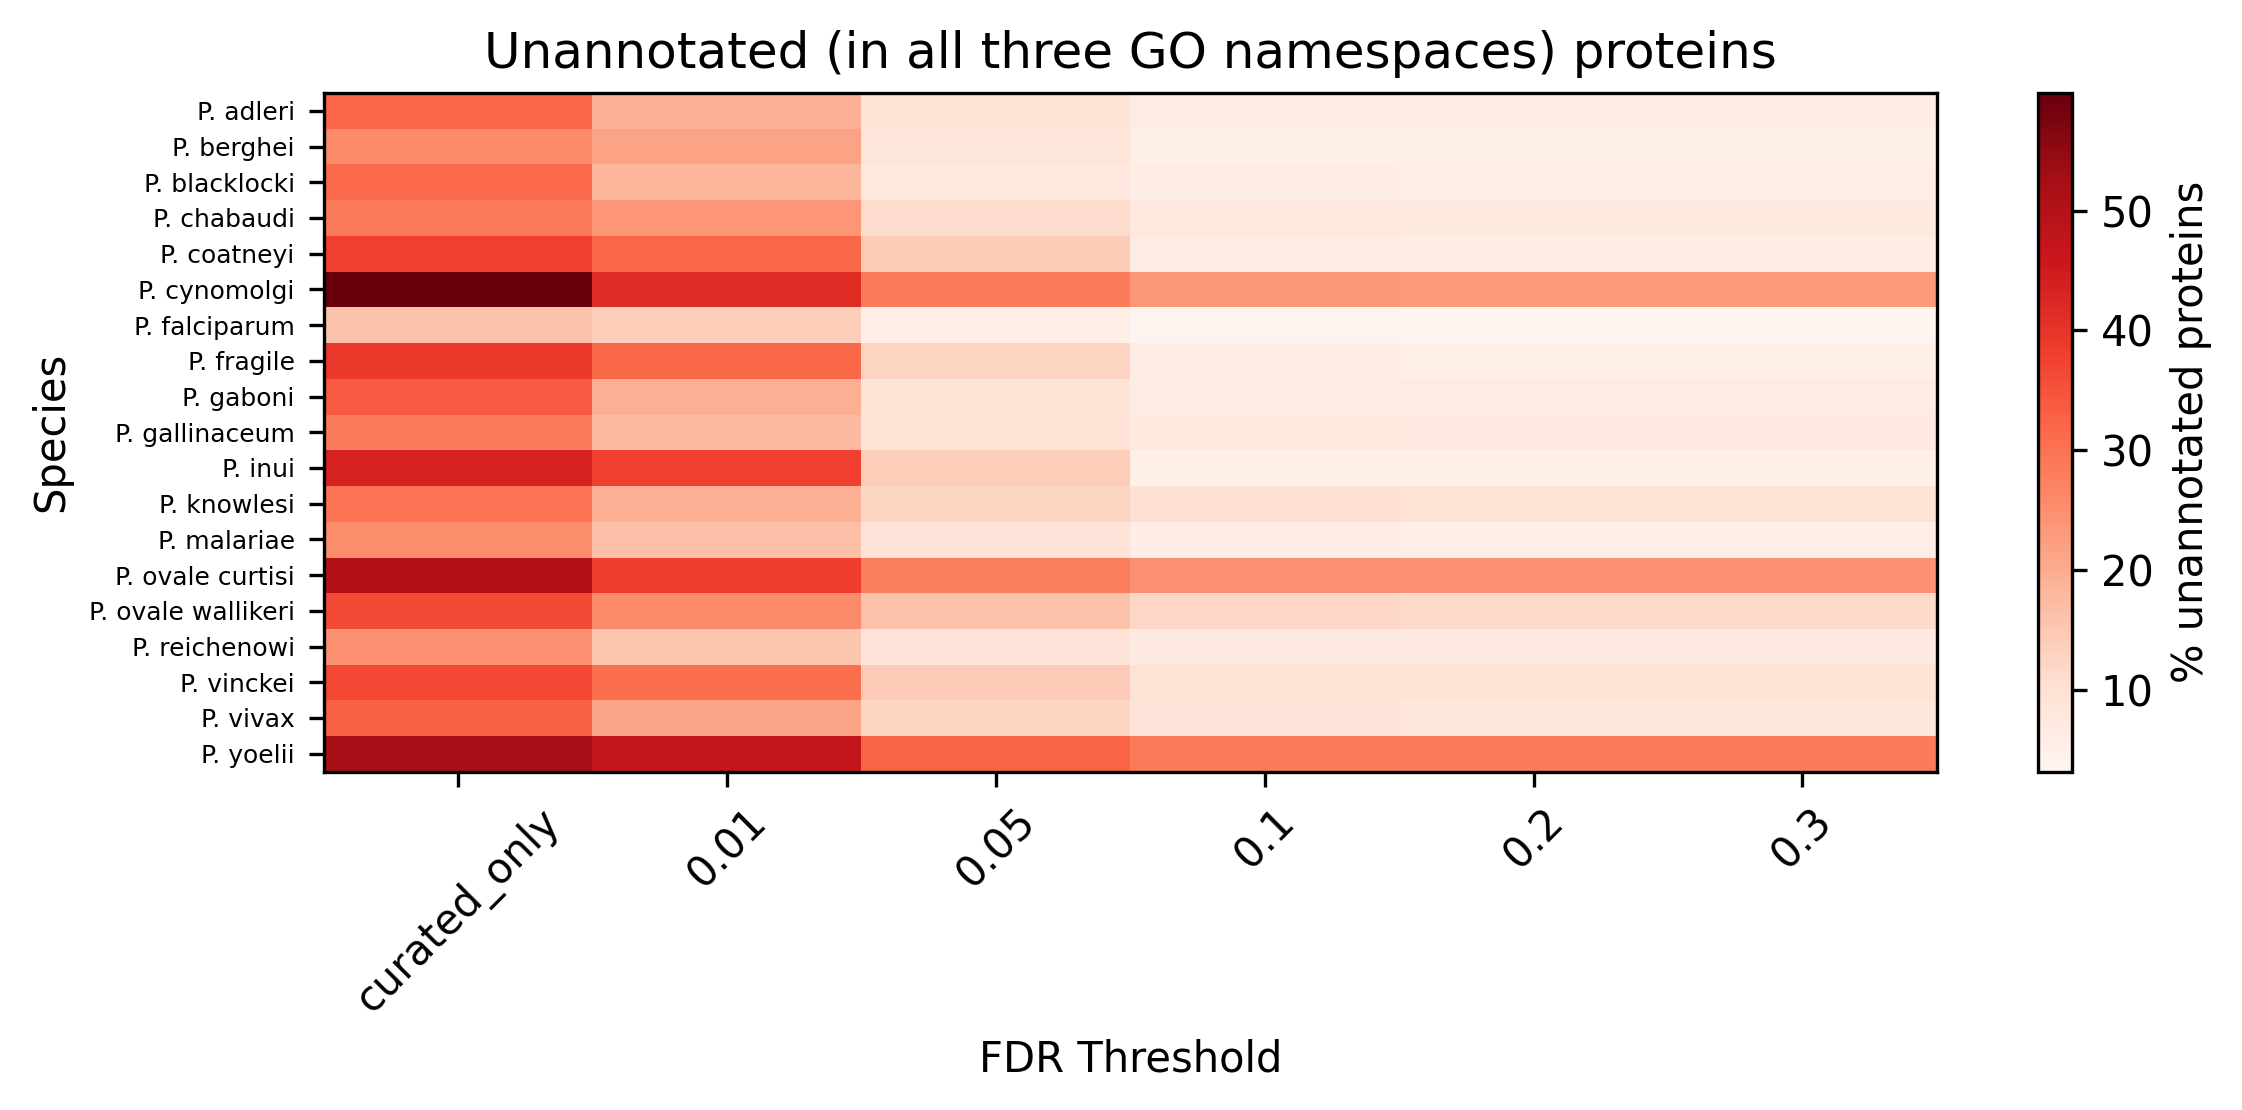

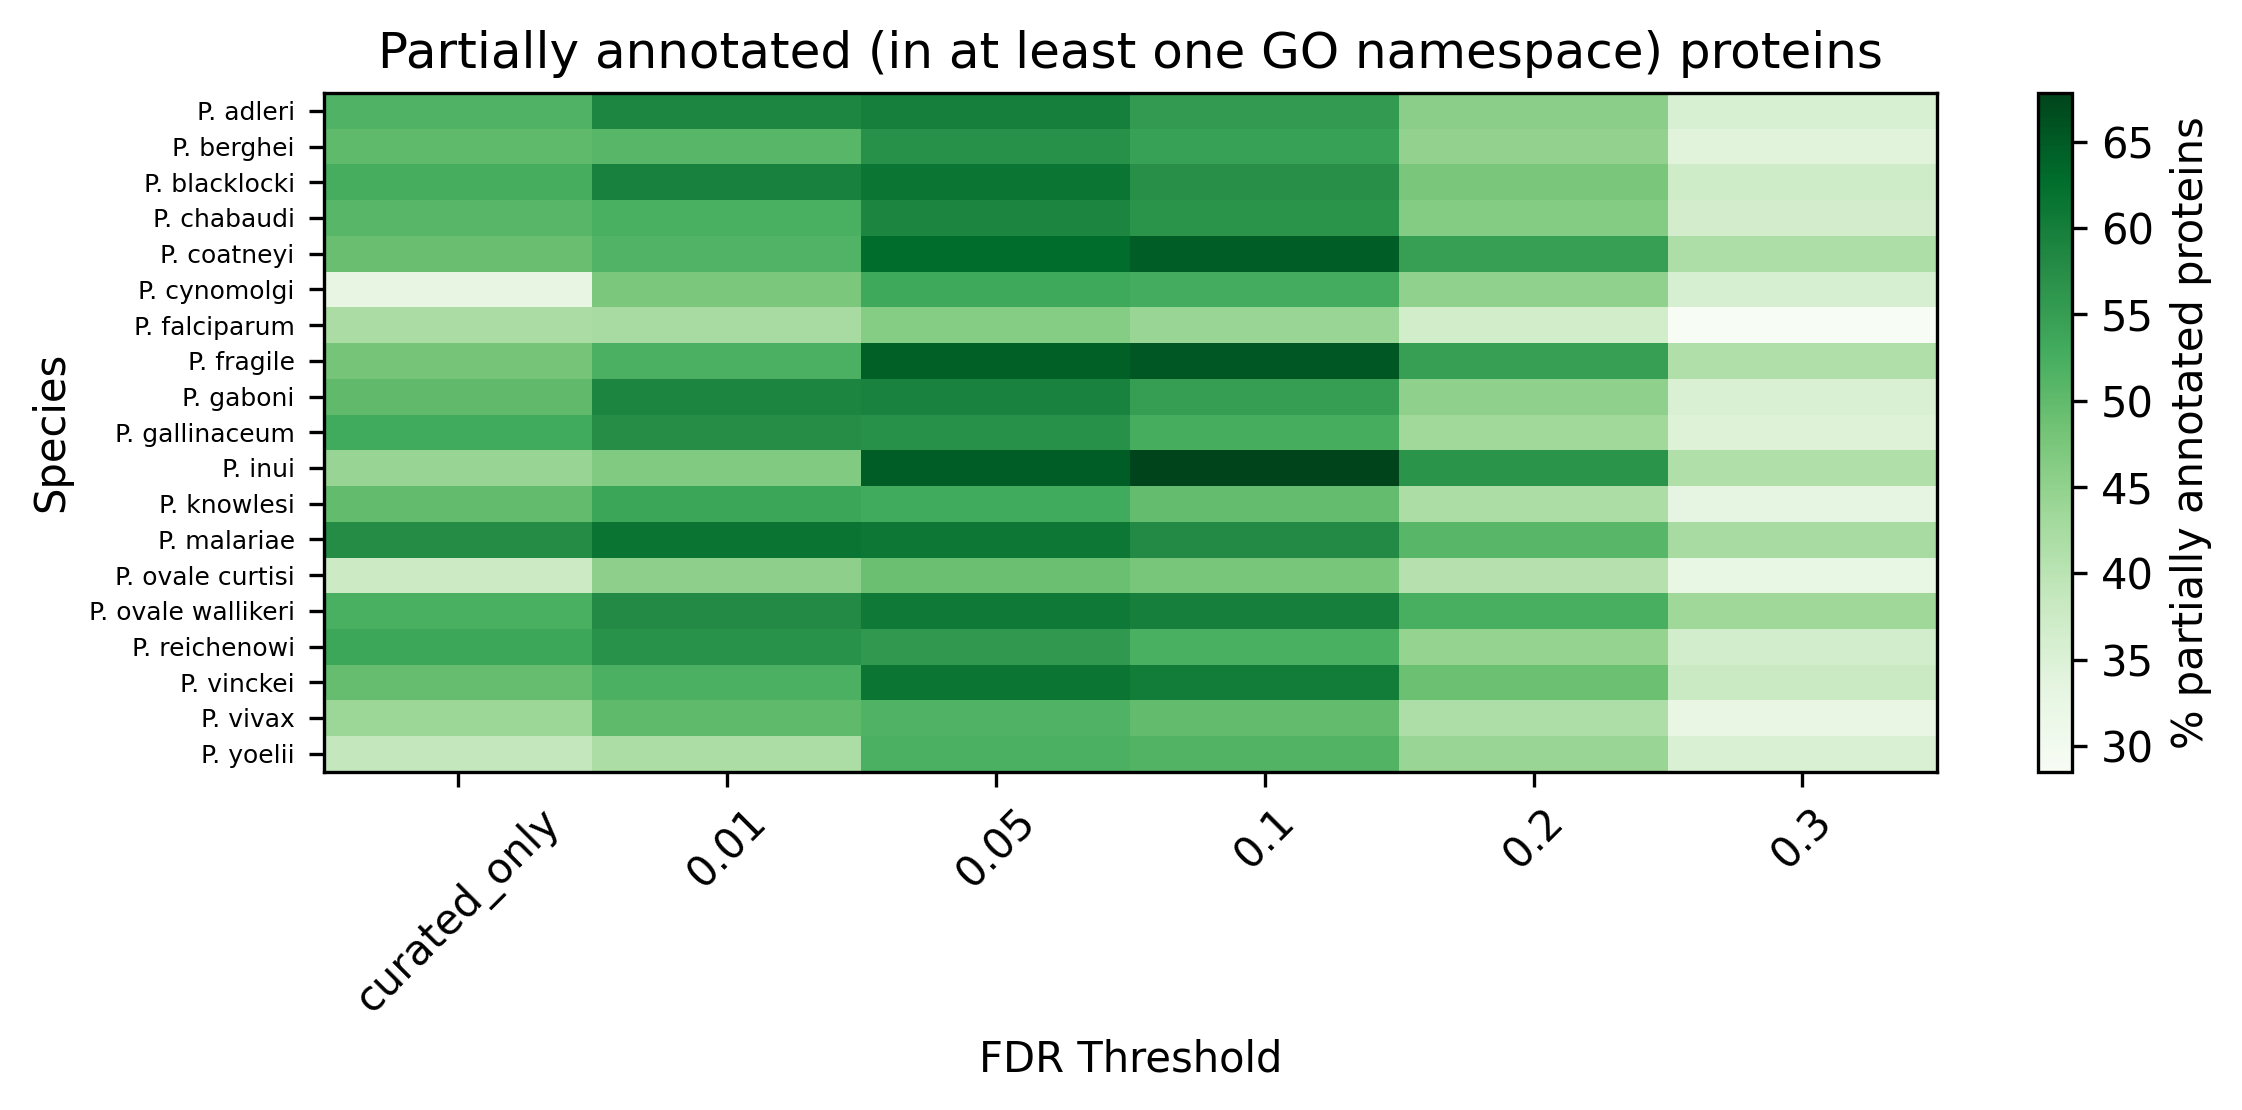

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1) Build a pivoted DataFrame: rows=species, cols=threshold, values=% fully_annotated
df_pct = (
    df
    .reset_index()
    .assign(
        total=lambda d: d[['unannotated','partially_annotated','fully_annotated']].sum(axis=1),
        pct_fully=lambda d: d['fully_annotated'] / d['total'] * 100
    )
    .pivot(index='species', columns='threshold', values='pct_fully')
)

#drop P-vivax P01 
df_pct = df_pct.drop('PlasmoDB-68_PvivaxP01')


# 2) Sort columns so 'curated_only' comes first
ordered_cols = sorted(df_pct.columns, key=lambda t: -1 if t=='curated_only' else float(t))
df_pct = df_pct[ordered_cols]

# 3) Plot heatmap with imshow
fig, ax = plt.subplots(figsize=(8, len(df_pct)*0.2))  # adjust height to # of species
im = ax.imshow(df_pct, aspect='auto', origin='lower', cmap='Blues')
#set dpi 
fig.dpi = 300
# 4) Labels
df_pct.index = df_pct.index.map(species_to_name)
ax.set_yticks(np.arange(len(df_pct.index)))
ax.set_yticklabels(df_pct.index, fontsize=6)
ax.set_xticks(np.arange(len(df_pct.columns)))
#rename x-tick labels 
x_labels = ['Existing in\PlasmoDB', '1%','5%', '10%', '20%', '30%']
ax.set_xticklabels(x_labels, rotation=45)
# ax.set_xticklabels([str(c) for c in df_pct.columns], rotation=45)

ax.set_xlabel('FDR Threshold')
ax.set_ylabel('Species')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('% fully annotated')
ax.invert_yaxis()

ax.set_title('Annotated (in all three GO namespaces) proteins')
fig.tight_layout()
plt.show()


# 1) Compute % unannotated and pivot
df_unann = (
    df
    .reset_index()
    .assign(
        total=lambda d: d[['unannotated','partially_annotated','fully_annotated']].sum(axis=1),
        pct_unannotated=lambda d: d['unannotated'] / d['total'] * 100
    )
    .pivot(index='species', columns='threshold', values='pct_unannotated')
)

#drop P-vivax P01
df_unann = df_unann.drop('PlasmoDB-68_PvivaxP01')
# 2) Sort thresholds so 'curated_only' comes first
ordered_cols = sorted(df_unann.columns, key=lambda t: -1 if t=='curated_only' else float(t))
df_unann = df_unann[ordered_cols]

# 3) Plot heatmap
fig, ax = plt.subplots(figsize=(8, len(df_unann)*0.2))
im = ax.imshow(df_unann, aspect='auto', origin='lower', cmap='Reds')
fig.dpi = 300

# 4) Axis labels & ticks
df_unann.index = df_unann.index.map(species_to_name)
ax.set_yticks(np.arange(len(df_unann.index)))
ax.set_yticklabels(df_unann.index, fontsize=6)
#using species_to_name to rename species
ax.set_xticks(np.arange(len(df_unann.columns)))
ax.set_xticklabels([str(c) for c in df_unann.columns], rotation=45)

ax.set_xlabel('FDR Threshold')
ax.set_ylabel('Species')
ax.invert_yaxis()

# 5) Colorbar & title
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('% unannotated proteins')
ax.set_title('Unannotated (in all three GO namespaces) proteins')

fig.tight_layout()
plt.show()


df_partial = (
    df
    .reset_index()
    .assign(
        total=lambda d: d[['unannotated','partially_annotated','fully_annotated']].sum(axis=1),
        pct_partial=lambda d: d['partially_annotated'] / d['total'] * 100
    )
    .pivot(index='species', columns='threshold', values='pct_partial')
)
#drop P-vivax P01
df_partial = df_partial.drop('PlasmoDB-68_PvivaxP01')
# Sort thresholds so 'curated_only' comes first
ordered_cols = sorted(df_partial.columns, key=lambda t: -1 if t=='curated_only' else float(t))
df_partial = df_partial[ordered_cols]
# Plot heatmap
fig, ax = plt.subplots(figsize=(8, len(df_partial)*0.2))
im = ax.imshow(df_partial, aspect='auto', origin='lower', cmap='Greens')
fig.dpi = 300
# Axis labels & ticks
df_partial.index = df_partial.index.map(species_to_name)
ax.set_yticks(np.arange(len(df_partial.index)))
ax.set_yticklabels(df_partial.index, fontsize=6)
ax.set_xticks(np.arange(len(df_partial.columns)))
ax.set_xticklabels([str(c) for c in df_partial.columns], rotation=45)
ax.set_xlabel('FDR Threshold')
ax.set_ylabel('Species')
ax.invert_yaxis()
# Colorbar & title
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('% partially annotated proteins')
ax.set_title('Partially annotated (in at least one GO namespace) proteins')
fig.tight_layout()
plt.show()


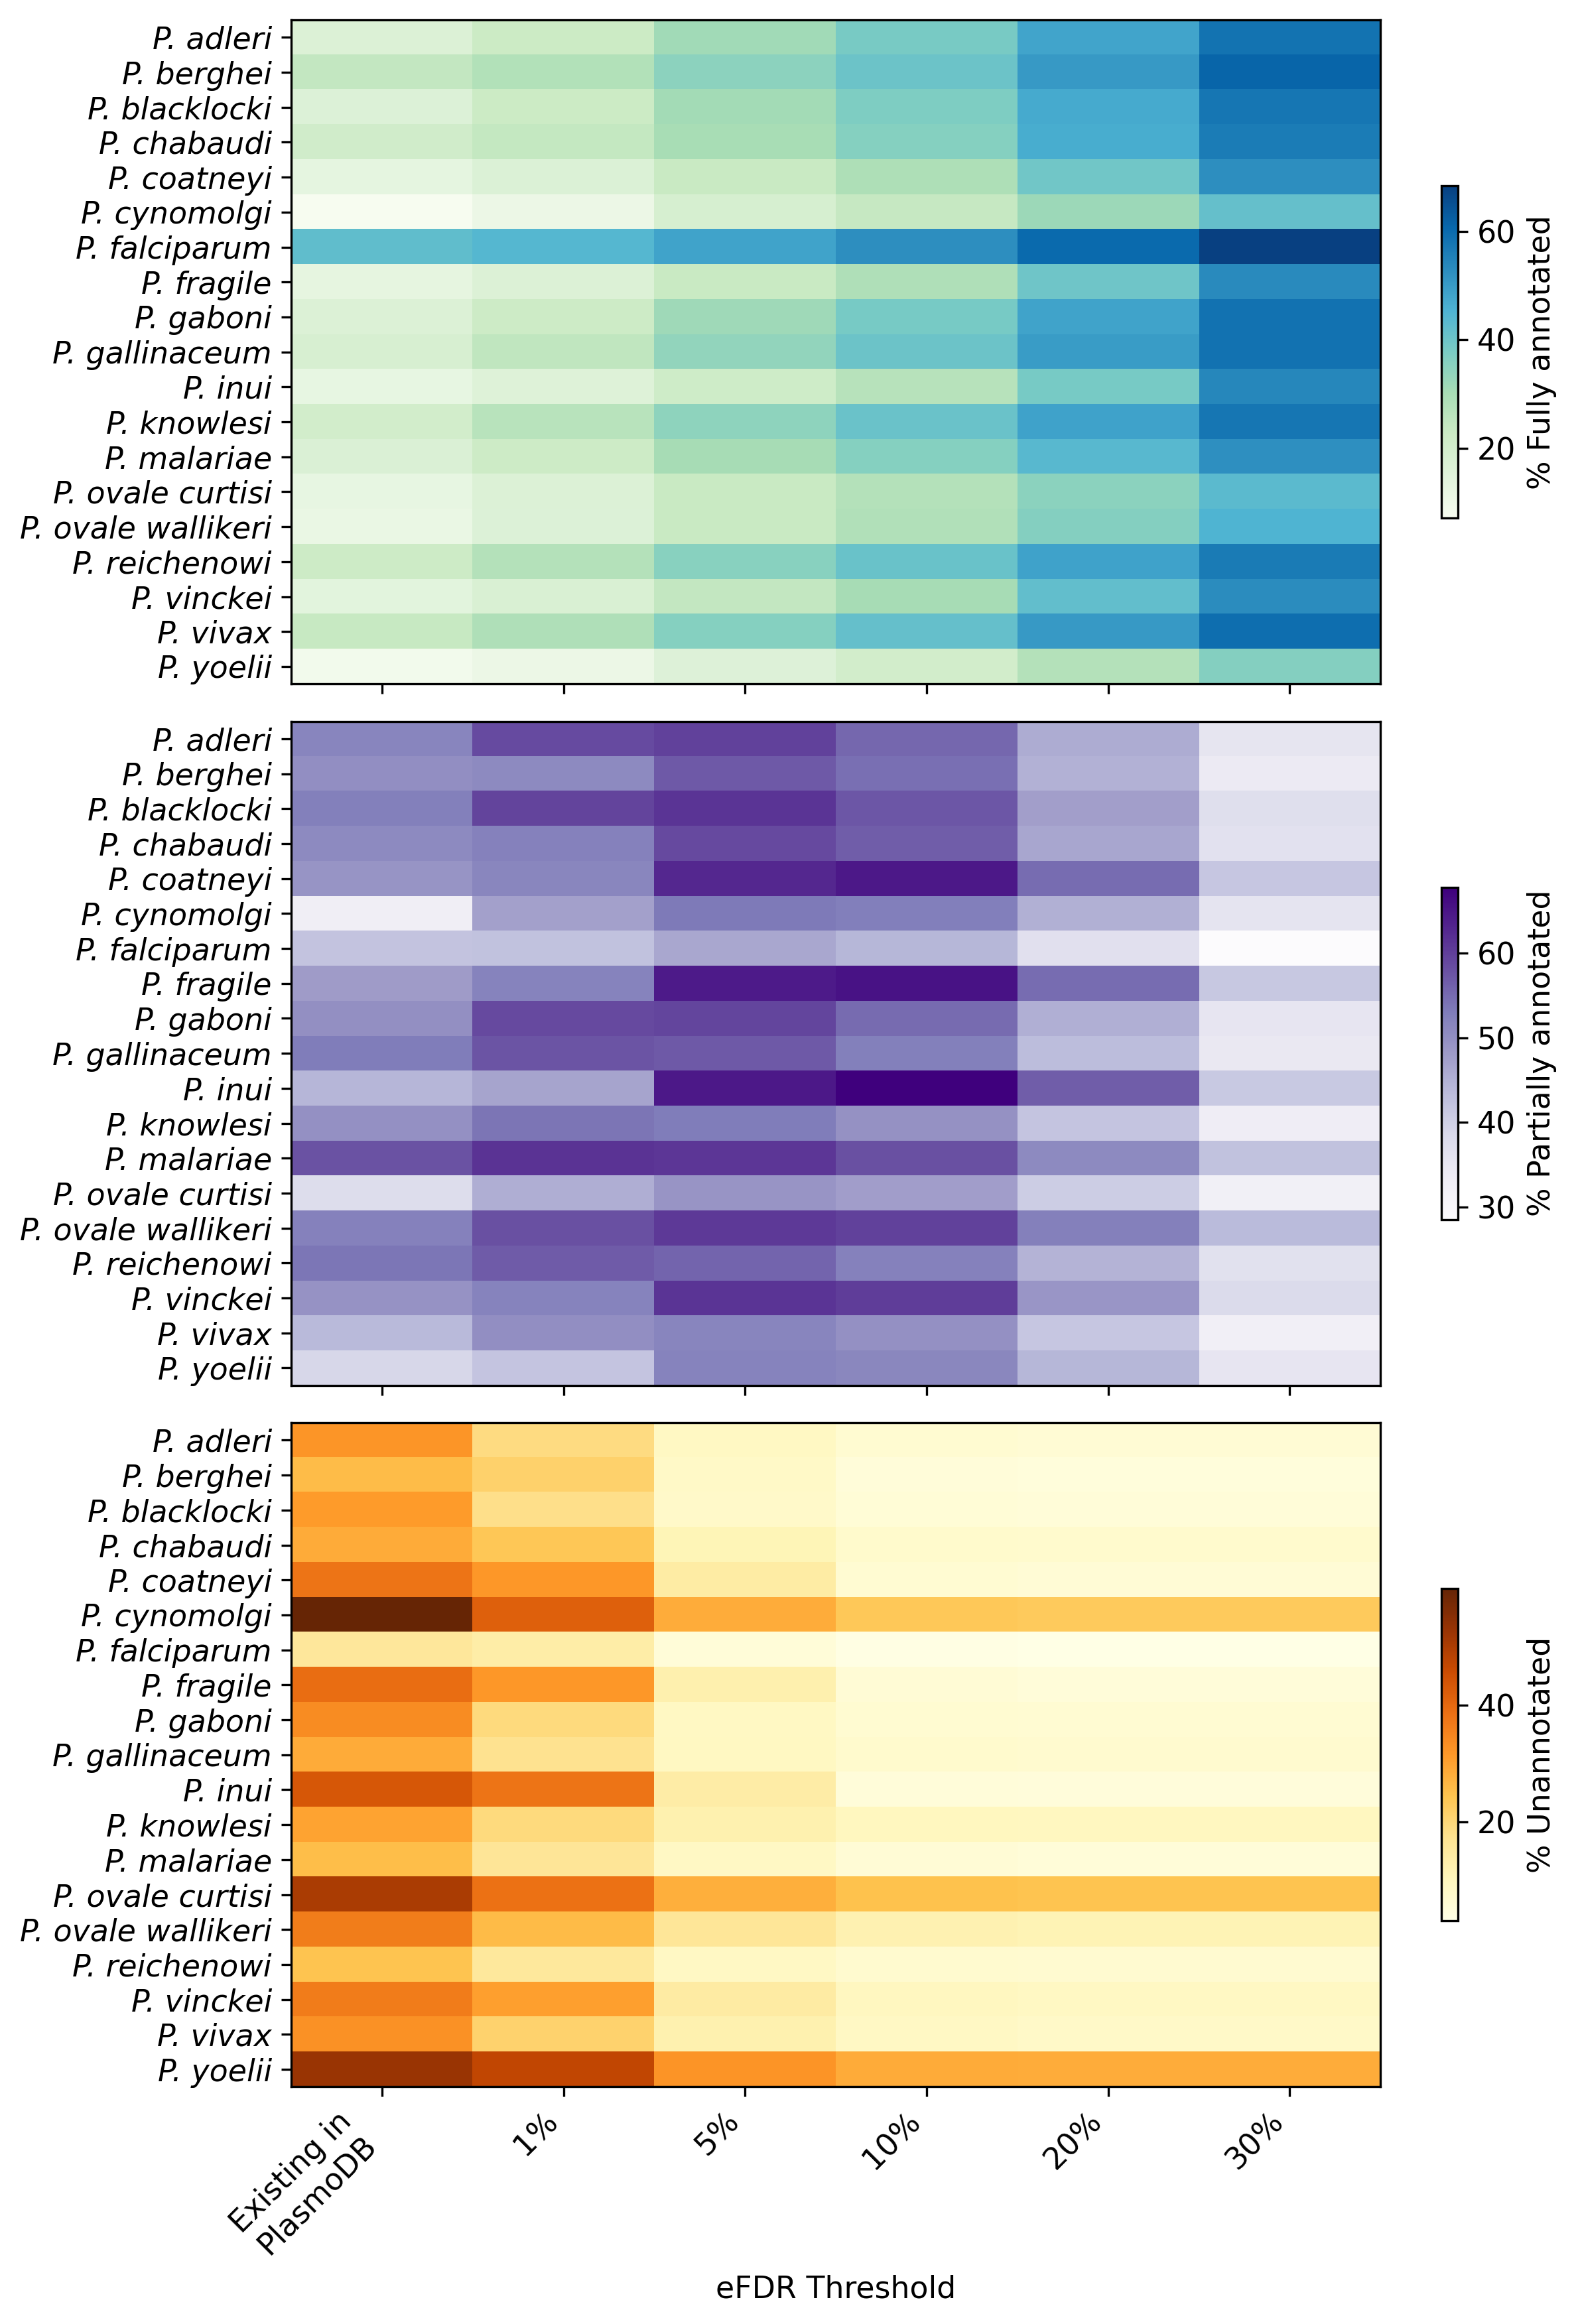

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# --- Step 0: remap all three indices in-place, preserving order ---
for df in (df_pct, df_partial, df_unann):
    df.index = [ species_to_name.get(s, s) for s in df.index ]

# Data + plotting params in a list for easy looping
plots = [
    (df_pct,    'GnBu',  'Annotated',      '% Fully annotated'),
    (df_partial,'Purples', 'Partially annotated', '% Partially annotated'),
    (df_unann,  'YlOrBr',   'Unannotated',  '% Unannotated'),
]

# create a figure with 3 rows, 1 col
fig, axes = plt.subplots(nrows=3, ncols=1,
                         figsize=(8, len(df_pct)*0.2*3.1),  # stack 3 panels
                         sharex=True)
fig.dpi = 300

for ax, (df_metric, cmap, title, cbar_label) in zip(axes, plots):
    im = ax.imshow(df_metric, aspect='auto', origin='lower', cmap=cmap)
    # ax.set_title(title, fontsize=11, pad=6)

    # y-ticks = remapped species names
    ax.set_yticks(np.arange(len(df_metric.index)))
    ax.set_yticklabels(df_metric.index, fontsize=11, fontstyle = 'italic')

    # only bottom plot shows the x-tick labels
    if ax is axes[-1]:
        ax.set_xticks(np.arange(len(df_metric.columns)))
        ax.set_xticklabels(['Existing in\nPlasmoDB','1%','5%','10%','20%','30%'],
                            rotation=45, ha='right', fontsize=11)
        ax.set_xlabel('eFDR Threshold', fontsize=11)
    else:
        ax.tick_params(labelbottom=False)

    # ax.set_ylabel('Species', fontsize=7)
    ax.invert_yaxis()

    # colorbar next to each subplot
    cbar = fig.colorbar(im, ax=ax, fraction=0.05, pad=0.05, orientation='vertical', shrink=0.5)
    # cbar.set_label(cbar_label, fontsize=6)
    cbar.ax.tick_params(labelsize=11)
    #set color bar label to font 11
    cbar.ax.set_ylabel(cbar_label, fontsize=11)

fig.tight_layout(h_pad=1.0)
plt.show()


In [33]:
df_pct

threshold,curated_only,0.01,0.05,0.1,0.2,0.3
P. adleri,16.375587,22.309859,31.136150,38.028169,48.206573,58.234742
P. berghei,24.223477,27.773296,34.691408,40.278338,50.282372,60.972166
P. blacklocki,16.235294,22.333333,30.882353,37.098039,47.019608,57.470588
P. chabaudi,20.696288,24.081554,30.063474,36.045393,46.374303,56.241585
P. coatneyi,13.161711,16.660624,23.078318,28.843365,39.213198,52.393038
P. cynomolgi,7.234674,10.942650,18.473962,23.714568,32.053395,41.529334
P. falciparum,42.271293,43.997031,48.320653,52.477269,60.159584,68.324364
P. fragile,12.905501,16.378702,23.043018,28.667137,39.827221,53.402680
P. gaboni,16.497857,21.893261,31.632256,38.313206,48.461239,58.356058
P. gallinaceum,18.444949,24.933787,33.768445,40.219448,49.735149,58.323874


In [27]:
df_partial

threshold,curated_only,0.01,0.05,0.1,0.2,0.3
P. adleri,51.605634,58.704225,59.812207,55.436620,45.577465,35.549296
P. berghei,50.161355,50.887455,56.918112,54.558290,44.796289,34.106495
P. blacklocki,52.529412,59.509804,61.235294,57.235294,47.509804,37.058824
P. chabaudi,50.894403,52.298519,58.876707,56.491633,46.355068,36.487786
P. coatneyi,49.111675,51.432197,62.799130,64.738941,54.804206,41.624365
P. cynomolgi,32.943309,47.396177,53.312459,52.768622,45.072512,35.613052
P. falciparum,42.030061,42.382631,46.223789,44.145482,36.685842,28.521061
P. fragile,47.990127,51.904090,64.368829,65.461918,54.848378,41.272920
P. gaboni,49.883132,58.784573,59.349435,55.025321,45.188937,35.313596
P. gallinaceum,53.045781,57.642830,56.923950,52.516080,43.227393,34.638668


In [28]:
df_unann

threshold,curated_only,0.01,0.05,0.1,0.2,0.3
P. adleri,32.018779,18.985915,9.051643,6.535211,6.215962,6.215962
P. berghei,25.615167,21.339250,8.390480,5.163372,4.921339,4.921339
P. blacklocki,31.235294,18.156863,7.882353,5.666667,5.470588,5.470588
P. chabaudi,28.409309,23.619927,11.059819,7.462974,7.270629,7.270629
P. coatneyi,37.726613,31.907179,14.122553,6.417694,5.982596,5.982596
P. cynomolgi,59.822017,41.661173,28.213579,23.516809,22.874094,22.857614
P. falciparum,15.698645,13.620338,5.455558,3.377250,3.154574,3.154574
P. fragile,39.104372,31.717207,12.588152,5.870945,5.324401,5.324401
P. gaboni,33.619011,19.322166,9.018309,6.661473,6.349825,6.330347
P. gallinaceum,28.509270,17.423383,9.307605,7.264472,7.037457,7.037457


In [29]:
df_unann

threshold,curated_only,0.01,0.05,0.1,0.2,0.3
P. adleri,32.018779,18.985915,9.051643,6.535211,6.215962,6.215962
P. berghei,25.615167,21.339250,8.390480,5.163372,4.921339,4.921339
P. blacklocki,31.235294,18.156863,7.882353,5.666667,5.470588,5.470588
P. chabaudi,28.409309,23.619927,11.059819,7.462974,7.270629,7.270629
P. coatneyi,37.726613,31.907179,14.122553,6.417694,5.982596,5.982596
P. cynomolgi,59.822017,41.661173,28.213579,23.516809,22.874094,22.857614
P. falciparum,15.698645,13.620338,5.455558,3.377250,3.154574,3.154574
P. fragile,39.104372,31.717207,12.588152,5.870945,5.324401,5.324401
P. gaboni,33.619011,19.322166,9.018309,6.661473,6.349825,6.330347
P. gallinaceum,28.509270,17.423383,9.307605,7.264472,7.037457,7.037457


In [36]:
#save to dfs 
df_pct.to_csv("annotation_stats/annotation_stats_full_FINAL.tsv", sep="\t")
df_partial.to_csv("annotation_stats/annotation_stats_partial_FINAL.tsv", sep="\t")
df_unann.to_csv("annotation_stats/annotation_stats_unann_FINAL.tsv", sep="\t")

In [37]:
#average at curated_only in df_pct
average_pct_fully = df_pct['curated_only'].mean()
#average at curated_only in df_unann
average_pct_unannotated = df_unann['curated_only'].mean()

#now at 0.3
average_pct_fully_0_3 = df_pct[0.3].mean()
average_pct_unannotated_0_3 = df_unann[0.3].mean()
print(f"Average % fully annotated at curated_only: {average_pct_fully:.2f}%")
print(f"Average % unannotated at curated_only: {average_pct_unannotated:.2f}%")
print(f"Average % fully annotated at 0.3: {average_pct_fully_0_3:.2f}%")
print(f"Average % unannotated at 0.3: {average_pct_unannotated_0_3:.2f}%")

# average_pct_fully_0_3-average_pct_fully
print("The difference in average % fully annotated between curated_only and 0.3 is: "
      f"{average_pct_fully_0_3 - average_pct_fully:.2f}%")
# average_pct_unannotated_0_3-average_pct_unannotated
print("The difference in average % unannotated between curated_only and 0.3 is: "
      f"{average_pct_unannotated_0_3 - average_pct_unannotated:.2f}%")

Average % fully annotated at curated_only: 17.35%
Average % unannotated at curated_only: 34.89%
Average % fully annotated at 0.3: 53.80%
Average % unannotated at 0.3: 9.60%
The difference in average % fully annotated between curated_only and 0.3 is: 36.44%
The difference in average % unannotated between curated_only and 0.3 is: -25.29%


In [18]:
#average at curated_only in df_pct
average_pct_fully = df_pct['curated_only'].mean()
#average at curated_only in df_unann
average_pct_unannotated = df_unann['curated_only'].mean()

#now at 0.3
average_pct_fully_0_3 = df_pct[0.3].mean()
average_pct_unannotated_0_3 = df_unann[0.3].mean()
print(f"Average % fully annotated at curated_only: {average_pct_fully:.2f}%")
print(f"Average % unannotated at curated_only: {average_pct_unannotated:.2f}%")
print(f"Average % fully annotated at 0.3: {average_pct_fully_0_3:.2f}%")
print(f"Average % unannotated at 0.3: {average_pct_unannotated_0_3:.2f}%")

# average_pct_fully_0_3-average_pct_fully
print("The difference in average % fully annotated between curated_only and 0.3 is: "
      f"{average_pct_fully_0_3 - average_pct_fully:.2f}%")
# average_pct_unannotated_0_3-average_pct_unannotated
print("The difference in average % unannotated between curated_only and 0.3 is: "
      f"{average_pct_unannotated_0_3 - average_pct_unannotated:.2f}%")

Average % fully annotated at curated_only: 17.35%
Average % unannotated at curated_only: 34.89%
Average % fully annotated at 0.3: 53.80%
Average % unannotated at 0.3: 9.60%
The difference in average % fully annotated between curated_only and 0.3 is: 36.44%
The difference in average % unannotated between curated_only and 0.3 is: -25.29%


In [30]:
#subtract df_pct 0.3 from df_pct curated_only
df_pct_diff = df_pct['curated_only'] - df_pct[0.3]
df_pct_diff_sorted = df_pct_diff.sort_values(ascending=False)
df_pct_diff_sorted

species
P. falciparum        -25.255149
P. yoelii            -26.890876
P. ovale curtisi     -30.280318
P. ovale wallikeri   -32.980090
P. cynomolgi         -33.602505
P. reichenowi        -33.848044
P. vivax             -34.538879
P. chabaudi          -34.775918
P. malariae          -34.836755
P. berghei           -35.639371
P. knowlesi          -36.373874
P. vinckei           -38.047847
P. coatneyi          -38.234228
P. gallinaceum       -39.197881
P. fragile           -39.404090
P. inui              -40.157750
P. blacklocki        -40.235294
P. adleri            -41.032864
P. gaboni            -41.079081
dtype: float64

In [38]:
#subtract df_pct 0.3 from df_pct curated_only
df_unann_diff = df_unann['curated_only'] - df_unann[0.3]
df_unann_diff_sorted = df_unann_diff.sort_values(ascending=False)
print(df_unann_diff_sorted)
#print range 
print(f"Range of df_unann_diff: {df_unann_diff.min()} to {df_unann_diff.max()}")

P. inui               38.477366
P. cynomolgi          36.964403
P. fragile            33.779972
P. coatneyi           31.744017
P. vinckei            27.387560
P. gaboni             27.288664
P. adleri             25.802817
P. ovale curtisi      25.798231
P. blacklocki         25.764706
P. ovale wallikeri    24.903661
P. vivax              24.575045
P. yoelii             24.308216
P. gallinaceum        21.471812
P. chabaudi           21.138681
P. berghei            20.693828
P. knowlesi           20.514264
P. malariae           19.976439
P. reichenowi         17.441656
P. falciparum         12.544071
dtype: float64
Range of df_unann_diff: 12.544071256262756 to 38.477366255144034


In [43]:
print(f"Range of df_annnotated : {df_pct[0.3].min()} to {df_pct[0.3].max()}")

Range of df_annnotated : 36.3417056903647 to 68.3243644460939


In [46]:
import pandas as pd

# Define the curated and PFP keys per sub-ontology
ontology_map = {
    'MF': ('GO Function', 'GO IEA Function', 'PFP MF'),
    'BP': ('GO Process', 'GO IEA Process', 'PFP BP'),
    'CC': ('GO Component', 'GO IEA Component', 'PFP CC'),
}
thresholds = [0.01, 0.05, 0.1, 0.2, 0.3]

records_ontology = []

for species, genes in gene_dicts.items():
    total_genes = len(genes)
    for ont, (cur_key, iea_key, pfp_key) in ontology_map.items():
        # Curated-only
        annotated = sum(bool(annot.get(cur_key, []) or annot.get(iea_key, []))
                        for annot in genes.values())
        unannotated = total_genes - annotated
        records_ontology.append({
            'species': species,
            'ontology': ont,
            'threshold': 'curated_only',
            'unannotated': unannotated,
            'annotated': annotated
        })
        # With PFP thresholds
        for t in thresholds:
            annotated_t = 0
            for annot in genes.values():
                curated_any = bool(annot.get(cur_key, []) or annot.get(iea_key, []))
                pfp_preds = annot.get(pfp_key, {}).get(t, set())
                if curated_any or pfp_preds:
                    annotated_t += 1
            unannotated_t = total_genes - annotated_t
            records_ontology.append({
                'species': species,
                'ontology': ont,
                'threshold': t,
                'unannotated': unannotated_t,
                'annotated': annotated_t
            })

df_per_ontology = pd.DataFrame(records_ontology)
df_per_ontology = df_per_ontology.set_index(['species', 'ontology', 'threshold'])
df_per_ontology.to_csv("annotation_stats/annotation_stats_per_ontology_FINAL.tsv", sep="\t")
df_per_ontology


unannotated  \
species                            ontology threshold                   
PlasmoDB-68_PinuiSanAntonio1       MF       curated_only         3720   
                                            0.01                 3207   
                                            0.05                 1366   
                                            0.1                   505   
                                            0.2                   433   
...                                                               ...   
PlasmoDB-68_PvinckeibrucechwattiDA CC       0.01                 3095   
                                            0.05                 2744   
                                            0.1                  2439   
                                            0.2                  1834   
                                            0.3                  1416   

                                                          annotated  
species                            ontology threshold                
PlasmoDB-68_PinuiSanAntonio1       MF       curated_only       2112  
                                            0.01               2625  
                                            0.05               4466  
                                            0.1                5327  
                                            0.2                5399  
...                                                             ...  
PlasmoDB-68_PvinckeibrucechwattiDA CC       0.01               2130  
                                            0.05               2481  
                                            0.1                2786  
                                            0.2                3391  
                                            0.3                3809  

[360 rows x 2 columns]